### Importação de bibliotecas

In [30]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
plt.rcParams['figure.figsize'] = (11,7) #apresenta todas as imagens na proporção definida

### Função de alinhamento usando ORB

In [31]:
MAX_FEATURES = 20000
GOOD_MATCH_PERCENT = 20

In [32]:
def orb_align(img1, img2):
    
    # Converte imagens para cinza
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) 
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) 
    height, width = img2.shape

    # Detecta recursos ORB
    orb_detector = cv2.ORB_create(MAX_FEATURES) 
    kp1, d1 = orb_detector.detectAndCompute(img1, None) 
    kp2, d2 = orb_detector.detectAndCompute(img2, None)
    
    # Match features (Recursos de combinações)
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True) 
    matches = matcher.match(d1, d2)

    # Organiza os matches por pontuação
    matches.sort(key=lambda x: x.distance)

    # Remova combinações não tão boas
    matches = matches[:int(len(matches)*GOOD_MATCH_PERCENT)] 
    no_of_matches = len(matches)
    
    # salva os melhores matches
    imgMatches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None)
    cv2.imwrite("matches.jpg", imgMatches)

    # Extrai a localizão do bons matches
    p1 = np.zeros((no_of_matches, 2)) 
    p2 = np.zeros((no_of_matches, 2))

    for i in range(len(matches)):
        p1[i, :] = kp1[matches[i].queryIdx].pt 
        p2[i, :] = kp2[matches[i].trainIdx].pt 
    
    # Encontra homografia
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC) 
    transformed_img = cv2.warpPerspective(img1, homography, (width, height))

    return transformed_img, homography 

### Função de alinhamento com SIFT

In [33]:
def sift_align(img1, img2):
    
    # Converte imagens para cinza
    img1Gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2Gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detecta recursos ORB
    sift = cv2.SIFT_create(5000)
    keypoints1, descriptors1 = sift.detectAndCompute(img1Gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2Gray, None)

    # Match features (Recursos de combinações)
    matcher = cv2.DescriptorMatcher_create(cv2.NORM_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Organiza os matches por pontuação
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remova combinações não tão boas
    numGoodMatches = int(len(matches) * 2)
    matches = matches[:numGoodMatches]

    # salva os melhores matches
    imgMatches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imgMatches)

    # Extrai a localizão do bons matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Encontra homografia
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Usa homografia
    height, width, channels = img2.shape
    
    img1Reg = cv2.warpPerspective(img1, h, (width, height))

    return img1Reg, h

### Função de detecção de bordas por matriz de convolução

Para esta função a imagem não deve estar me preto e branco

In [34]:
def edgesFunction(image):
    convolution_matrix = np.array([[0,1,0],
                                  [1,-4,1],
                                  [0,1,0]]) #filtro/matriz para detecção de bordas
    return cv2.filter2D(image, -1, convolution_matrix)

### Função que melhora a nitidez

In [35]:
def sharpenFunction(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) #matriz de convolução que aplica nitidez
    return cv2.filter2D(image, -1, kernel)

### Função de filtragem usando adaptativeThreshold

In [56]:
def filterFunction(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    Thresh1 = cv2.adaptiveThreshold(image, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 231,50)
    return Thresh1

### Lendo imagens e aplicando as funções de pré-processamento

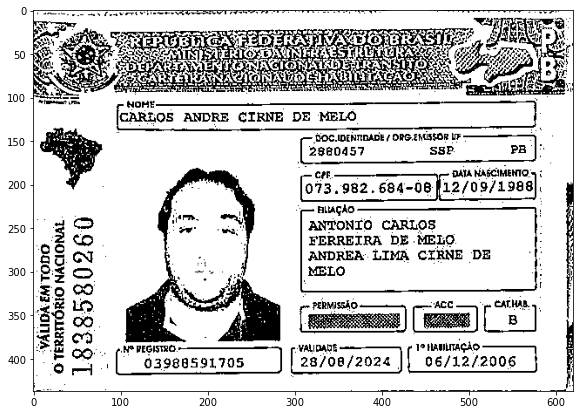

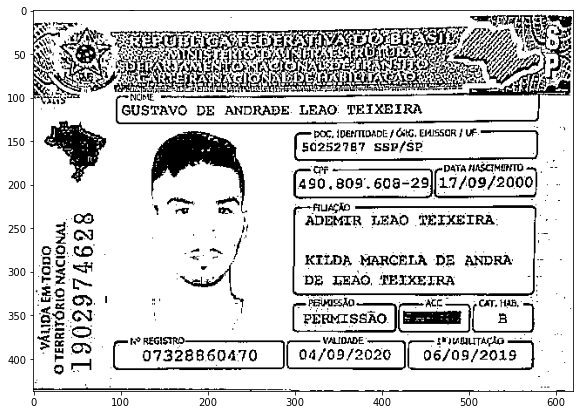

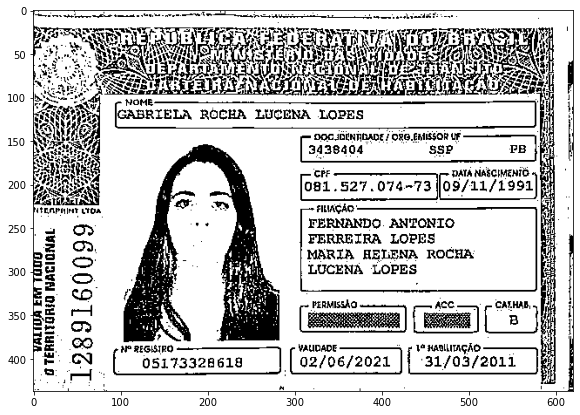

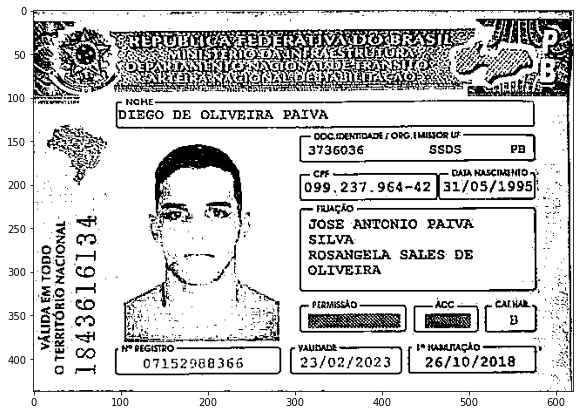

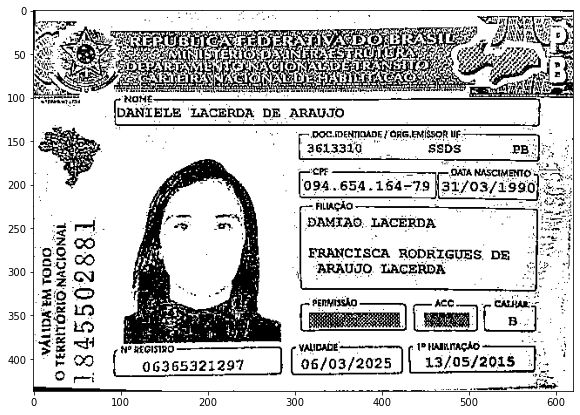

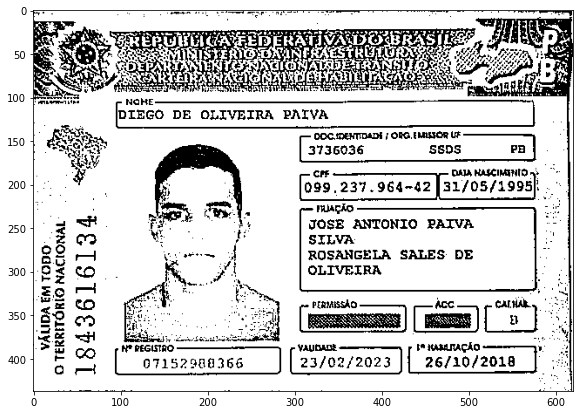

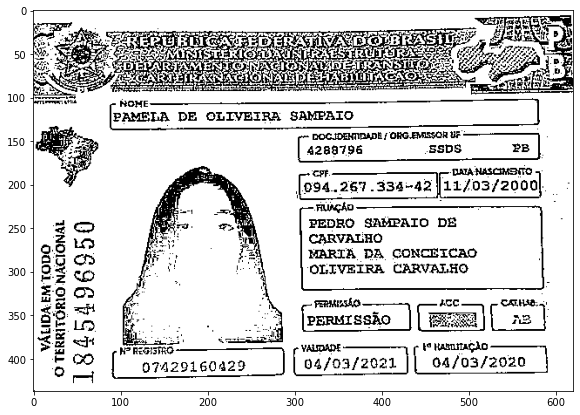

In [58]:
#lendo imagem (converte pra arrays)
imgs = glob.glob("../goodimages/*.jpeg")

imgReference = cv2.imread("../goodimages/aligned.jpeg")

for c in imgs:
    #Lendo todas as imagens que estão na pasta e plotando
    img = cv2.imread(c) #se quiser já ler cinza coloca (fh,0)

    """
    realinhadaORB, h = orb_align(img, imgReference)
    plt.imshow(cv2.cvtColor(realinhadaORB, cv2.COLOR_BGR2RGB))
    plt.show()
    """
   
    realinhadaSIFT, h = sift_align(img, imgReference)
    #plt.imshow(cv2.cvtColor(realinhadaSIFT, cv2.COLOR_BGR2RGB))
    #plt.show()
    
    #aplicando nitidez
    nitida = sharpenFunction(realinhadaSIFT)
     
    #filtros adaptativethreshold para correção e intensificação da imagem
    filt = filterFunction(nitida) # a melhor até agora :)
    plt.imshow(cv2.cvtColor(filt, cv2.COLOR_BGR2RGB))
    plt.show()  
         
    #blur = cv2.medianBlur(filt, 3)
    #plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
    #plt.show()
    
    cv2.imwrite("semfiltro.jpg", nitida)
    cv2.imwrite("processada.jpg", filt)

In [ ]:
print(filt.shape)
#print(realinhadaSIFT.shape)

### PRÓXIMOS PASSOS:

Aplicar um treinamento de machine learning para coletar os recursos em comum nas cnhs e armazenas seus descritores:
    - Criar um conjunto de dados com imagens alinhadas, porém diversas
    - Aplicar algum algoritmo de machine learning para reconhecimento e coleta desses recursos e keypoints nas imagens para termos esses dados como nossa referência
    - A partir dos Keypoints coletados aplicar a função de alinhamento
    
Para isso:
    - Ler sobre alinhamento de imagens
    - Encontrar qual/quais melhores algoritmos de machine learning podem ser usados para esse objetivo
    - Entender como vão ser coletados esses dados e definidos como dados de referência 